<a href="https://colab.research.google.com/github/Skeo220/time-series-deep-learning-EUR-USD/blob/main/EUR_USD_modeling_702010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import seaborn as sns
import tensorflow as tf

# Loading the dataset

In [ ]:
# Load the data from the CSV file
path = '/content/eur_usd.csv'  # Insert the dataset path here
df = pd.read_csv(path)

# List of columns to drop
cols_to_drop = ['Volume', 'Adj Close']

# Drop the specified columns from the DataFrame
df = df.drop(cols_to_drop, axis=1)

# Display the first few rows of the DataFrame
df.head()

,Date,Open,High,Low,Close
0,2003-12-01,1.203398,1.204007,1.194401,1.196501
1,2003-12-02,1.196101,1.210903,1.194600,1.208897
2,2003-12-03,1.209000,1.213003,1.207700,1.212298
3,2003-12-04,1.212004,1.214403,1.204398,1.208094
4,2003-12-05,1.207802,1.219096,1.206593,1.218695


# Deep Learning/Neural Net

In [ ]:
# pip install tensorflow

In [ ]:
# importing libraries
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')


## Feature Engineering

In [ ]:
# transforming the date index
df['Date'] = pd.to_datetime(df['Date'])
df['day_sin'] = np.sin(2 * np.pi * df['Date'].dt.dayofweek / 5)
df['day_cos'] = np.cos(2 * np.pi * df['Date'].dt.dayofweek / 5)
df = df.drop('Date', axis = 1)

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,5159.0,1.238286,0.126469,0.959619,1.128751,1.226603,1.331398,1.598184
High,5159.0,1.242917,0.127188,0.967006,1.132625,1.231497,1.336550,1.602821
Low,5159.0,1.233230,0.126844,0.072902,1.124500,1.221300,1.325646,1.587402
Close,5159.0,1.238310,0.126463,0.959619,1.128776,1.226813,1.331452,1.598798
day_sin,5159.0,-0.000694,0.707120,-0.951057,-0.587785,0.000000,0.587785,0.951057
day_cos,5159.0,-0.000060,0.707231,-0.809017,-0.809017,0.309017,0.309017,1.000000


## Splitting the dataset

In [ ]:
def split_data(df):
    n = len(df)

    # Split 70:20:10 (train:validation:test)
    train_df = df[0:int(n*0.7)].reset_index(drop=True)
    val_df = df[int(n*0.7):int(n*0.9)].reset_index(drop=True)
    test_df = df[int(n*0.9):].reset_index(drop=True)

    return train_df, val_df, test_df

In [ ]:
train_df, val_df, test_df = split_data(df)

In [ ]:
print(train_df.shape, val_df.shape, test_df.shape)

(3611, 6) (1032, 6) (516, 6)


## Scaling the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

MinMaxScaler()

In [ ]:
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [ ]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,3611.0,0.439174,0.212820,0.0,2.986048e-01,0.455092,0.575868,1.0
High,3611.0,0.442146,0.212883,0.0,3.017036e-01,0.457732,0.576648,1.0
Low,3611.0,0.796412,0.079425,0.0,7.448909e-01,0.802767,0.847504,1.0
Close,3611.0,0.439080,0.212439,0.0,2.988926e-01,0.455109,0.574787,1.0
day_sin,3611.0,0.499479,0.371726,0.0,1.909830e-01,0.500000,0.809017,1.0
day_cos,3611.0,0.446919,0.391010,0.0,1.110223e-16,0.618034,0.618034,1.0


In [ ]:
train_df.to_csv('train_df.csv')
val_df.to_csv('val_df.csv')
test_df.to_csv('test_df.csv')

## Model Preparations

In [ ]:
# implimenting Datawindow()
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Close', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (d)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [ ]:
# implementing a multistep model
multi_window = DataWindow(input_width=14, label_width=14, shift=14,
                          label_columns=['Close'])

## Implementing deep neural networks

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [ ]:
import itertools

# Define hyperparameter combinations to explore
activation_functions = ['relu', 'tanh', 'elu', 'leaky_relu']
layer_sizes = [32, 64, 128]
combinations = list(itertools.product(activation_functions, layer_sizes))

# Create dictionaries to store results
results = {'combination': [], 'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': [], 'test_mae':[], 'aic': [], 'bic': []}

# Loop through hyperparameter combinations
for combo in combinations:
    activation_function, layer_size = combo

    # Create and compile the model with the current hyperparameters
    model = Sequential([
        Dense(layer_size, activation=activation_function),
        Dense(layer_size, activation=activation_function),
        Dense(1, kernel_initializer=tf.initializers.zeros),
    ])

    history = compile_and_fit(model, multi_window)

    # Calculate AIC and BIC
    n = len(multi_window.train_df)
    k = len(model.trainable_variables)
    train_mae = model.evaluate(multi_window.train)[1]
    val_mae = model.evaluate(multi_window.val)[1]
    test_mae = model.evaluate(multi_window.test)[1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    aic = n * np.log(train_loss) + 2 * k
    bic = n * np.log(train_loss) + k * np.log(n)

    # Store results
    results['combination'].append(combo)
    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_loss)
    results['train_mae'].append(train_mae)
    results['val_mae'].append(val_mae)
    results['test_mae'].append(test_mae)
    results['aic'].append(aic)
    results['bic'].append(bic)

# Convert results to a DataFrame for easy analysis
import pandas as pd
results_df = pd.DataFrame(results)

# Sort results by AIC or BIC, or any other metric you want to use for model selection
sorted_results = results_df.sort_values(by='aic', ascending=True)

# Display the best model based on AIC or BIC
best_model = sorted_results.iloc[0]
print("Best Model (based on AIC):", best_model)


Epoch 1/50
112/112 [==============================] - 2s 9ms/step - loss: 0.0655 - mean_absolute_error: 0.1825 - val_loss: 0.0053 - val_mean_absolute_error: 0.0622
Epoch 2/50
112/112 [==============================] - 1s 6ms/step - loss: 0.0036 - mean_absolute_error: 0.0458 - val_loss: 8.4820e-04 - val_mean_absolute_error: 0.0226
Epoch 3/50
112/112 [==============================] - 1s 5ms/step - loss: 0.0031 - mean_absolute_error: 0.0417 - val_loss: 8.4524e-04 - val_mean_absolute_error: 0.0226
Epoch 4/50
112/112 [==============================] - 1s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0415 - val_loss: 7.8532e-04 - val_mean_absolute_error: 0.0212
Epoch 5/50
112/112 [==============================] - 1s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0415 - val_loss: 9.2368e-04 - val_mean_absolute_error: 0.0237
Epoch 6/50
112/112 [==============================] - 1s 6ms/step - loss: 0.0031 - mean_absolute_error: 0.0416 - val_loss: 8.1294e-04 - val_mean_absolute_error: 0.0

In [ ]:
results_df

,combination,train_loss,val_loss,train_mae,val_mae,test_mae,aic,bic
0,"(relu, 32)",0.003036,0.000817,0.041015,0.021834,0.041346,-20921.244415,-20884.093975
1,"(relu, 64)",0.003099,0.000833,0.040856,0.021786,0.037527,-20847.757180,-20810.606740
2,"(relu, 128)",0.003139,0.000836,0.040704,0.021805,0.034236,-20801.755970,-20764.605530
3,"(tanh, 32)",0.003151,0.000840,0.041624,0.021591,0.029701,-20787.905206,-20750.754766
4,"(tanh, 64)",0.003282,0.000957,0.043214,0.023091,0.031963,-20640.338990,-20603.188550
5,"(tanh, 128)",0.003180,0.000848,0.041362,0.022120,0.030303,-20754.531633,-20717.381193
6,"(elu, 32)",0.003096,0.000830,0.041163,0.022036,0.030185,-20851.591486,-20814.441046
7,"(elu, 64)",0.003094,0.000929,0.041613,0.023753,0.030759,-20852.873663,-20815.723223
8,"(elu, 128)",0.003104,0.001260,0.044351,0.029033,0.033345,-20841.657289,-20804.506849
9,"(leaky_relu, 32)",0.003059,0.000848,0.040999,0.022354,0.034258,-20895.055898,-20857.905457


In [ ]:
best_model

combination      (relu, 32)
train_loss         0.003036
val_loss           0.000817
train_mae          0.041015
val_mae            0.021834
test_mae           0.041346
aic           -20921.244415
bic           -20884.093975
Name: 0, dtype: object

In [ ]:
val_performance = {}
performance = {}

In [ ]:
# Define the best model combination
best_model_combo = best_model['combination']

# Extract hyperparameters from the best model combination
activation_function, layer_size = best_model_combo

# Create the best model with the chosen hyperparameters
best_model = Sequential([
    Dense(layer_size, activation=activation_function),
    Dense(layer_size, activation=activation_function),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

# Compile and fit the best model
history = compile_and_fit(best_model, multi_window)

# Evaluate the best model on the validation set
val_performance['Best_Model'] = best_model.evaluate(multi_window.val)

# Evaluate the best model on the test set
performance['Best_Model'] = best_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
112/112 [==============================] - 2s 7ms/step - loss: 0.0549 - mean_absolute_error: 0.1609 - val_loss: 0.0013 - val_mean_absolute_error: 0.0290
Epoch 2/50
112/112 [==============================] - 1s 5ms/step - loss: 0.0031 - mean_absolute_error: 0.0421 - val_loss: 7.8021e-04 - val_mean_absolute_error: 0.0212
Epoch 3/50
112/112 [==============================] - 1s 5ms/step - loss: 0.0031 - mean_absolute_error: 0.0415 - val_loss: 8.4886e-04 - val_mean_absolute_error: 0.0218
Epoch 4/50
112/112 [==============================] - 1s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0415 - val_loss: 8.0566e-04 - val_mean_absolute_error: 0.0213
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 8.4268e-04 - mean_absolute_error: 0.0218


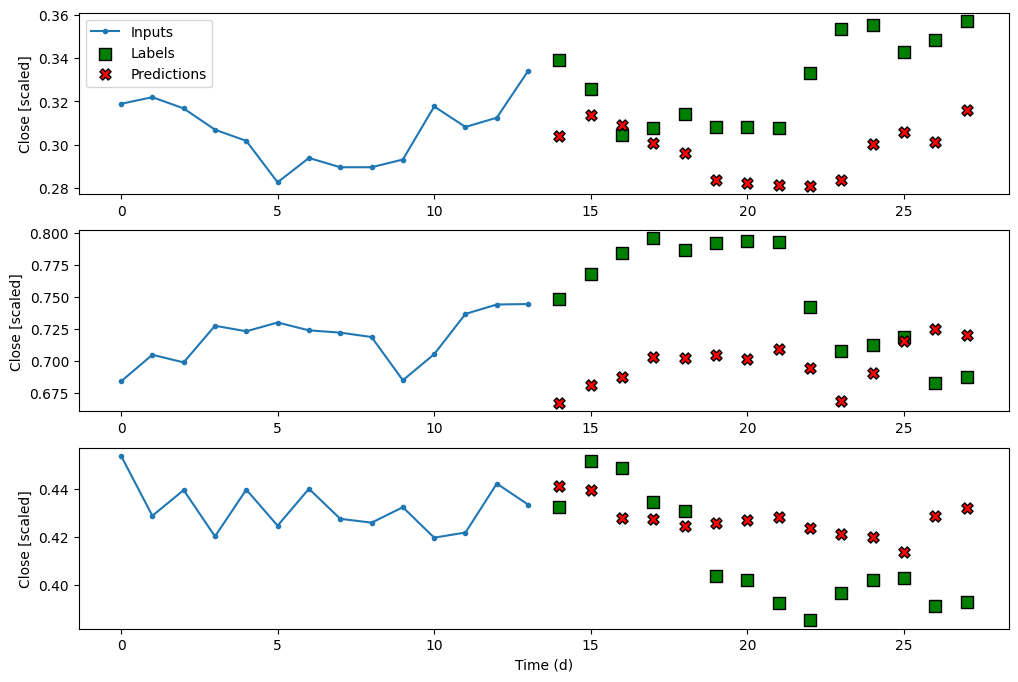

In [ ]:
# Use the best_model to plot the data
multi_window.plot(best_model)

# LSTM

In [ ]:
# importing libraries
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define hyperparameter combinations to explore for LSTM layers
lstm_layers = [1, 2]  # Number of LSTM layers
lstm_layer_sizes = [32, 64, 128]  # Number of neurons in each LSTM layer

lstm_combinations = list(itertools.product(lstm_layers, lstm_layer_sizes))

# Create dictionaries to store results
lstm_results = {'combination': [], 'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': [], 'test_mae':[], 'aic': [], 'bic': []}

# Initialize variables to track the best LSTM model
best_lstm_combo = None
best_lstm_aic = float('inf')  # Initialize with a high value

# Loop through LSTM hyperparameter combinations
for lstm_combo in lstm_combinations:
    num_lstm_layers, lstm_layer_size = lstm_combo

    # Create a sequential model
    lstm_model = Sequential()

    # Add the specified number of LSTM layers with the same number of neurons
    for _ in range(num_lstm_layers):
        lstm_model.add(LSTM(lstm_layer_size, return_sequences=True))

    # Add a Dense output layer
    lstm_model.add(Dense(1, kernel_initializer=tf.initializers.zeros))

    # Compile and fit the LSTM model
    lstm_history = compile_and_fit(lstm_model, multi_window)

    # Calculate AIC and BIC
    n = len(multi_window.train_df)
    k = len(lstm_model.trainable_variables)
    train_mae = lstm_model.evaluate(multi_window.train)[1]
    val_mae = lstm_model.evaluate(multi_window.val)[1]
    test_mae = lstm_model.evaluate(multi_window.test)[1]
    train_loss = lstm_history.history['loss'][-1]
    val_loss = lstm_history.history['val_loss'][-1]
    aic = n * np.log(train_loss) + 2 * k
    bic = n * np.log(train_loss) + k * np.log(n)

    # Store LSTM results
    lstm_results['combination'].append(lstm_combo)
    lstm_results['train_loss'].append(train_loss)
    lstm_results['val_loss'].append(val_loss)
    lstm_results['train_mae'].append(train_mae)
    lstm_results['val_mae'].append(val_mae)
    lstm_results['test_mae'].append(test_mae)
    lstm_results['aic'].append(aic)
    lstm_results['bic'].append(bic)

    # Check if this LSTM model has a lower AIC, indicating it's better
    if aic < best_lstm_aic:
        best_lstm_aic = aic
        best_lstm_combo = lstm_combo

# Convert LSTM results to a DataFrame for easy analysis
import pandas as pd
lstm_results_df = pd.DataFrame(lstm_results)

# Sort LSTM results by AIC or BIC, or any other metric you want to use for model selection
sorted_lstm_results = lstm_results_df.sort_values(by='aic', ascending=True)

# Display the best LSTM model based on AIC or BIC
best_lstm_model = sorted_lstm_results.iloc[0]
print("Best LSTM Model (based on AIC):", best_lstm_model)

# Create a separate DataFrame for the best LSTM model combo
best_lstm_combo_df = pd.DataFrame({
    'combination': [best_lstm_combo],
    'train_loss': [best_lstm_model['train_loss']],
    'val_loss': [best_lstm_model['val_loss']],
    'train_mae': [best_lstm_model['train_mae']],
    'val_mae': [best_lstm_model['val_mae']],
    'aic': [best_lstm_model['aic']],
    'bic': [best_lstm_model['bic']]
})

print("Best LSTM Model Combo:", best_lstm_combo_df)

Epoch 1/50
112/112 [==============================] - 5s 17ms/step - loss: 0.0664 - mean_absolute_error: 0.1909 - val_loss: 0.0062 - val_mean_absolute_error: 0.0650
Epoch 2/50
112/112 [==============================] - 2s 20ms/step - loss: 0.0122 - mean_absolute_error: 0.0761 - val_loss: 0.0033 - val_mean_absolute_error: 0.0438
Epoch 3/50
112/112 [==============================] - 2s 20ms/step - loss: 0.0070 - mean_absolute_error: 0.0590 - val_loss: 0.0024 - val_mean_absolute_error: 0.0365
Epoch 4/50
112/112 [==============================] - 2s 13ms/step - loss: 0.0052 - mean_absolute_error: 0.0525 - val_loss: 0.0021 - val_mean_absolute_error: 0.0342
Epoch 5/50
112/112 [==============================] - 2s 13ms/step - loss: 0.0043 - mean_absolute_error: 0.0488 - val_loss: 0.0019 - val_mean_absolute_error: 0.0338
Epoch 6/50
112/112 [==============================] - 2s 13ms/step - loss: 0.0039 - mean_absolute_error: 0.0467 - val_loss: 0.0016 - val_mean_absolute_error: 0.0307
Epoch 7/50

In [ ]:
# Use the best LSTM model from the previous code
best_lstm_model = Sequential()

# Add the number of LSTM layers and neurons from the best LSTM combo
num_lstm_layers, lstm_layer_size = best_lstm_combo
for _ in range(num_lstm_layers):
    best_lstm_model.add(LSTM(lstm_layer_size, return_sequences=True))

# Add a Dense output layer
best_lstm_model.add(Dense(1, kernel_initializer=tf.initializers.zeros))

# Compile and fit the best LSTM model
lstm_history = compile_and_fit(best_lstm_model, multi_window)

# Evaluate the best LSTM model on the validation set
val_performance['Best_LSTM'] = best_lstm_model.evaluate(multi_window.val)

# Evaluate the best LSTM model on the test set
performance['Best_LSTM'] = best_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
112/112 [==============================] - 6s 24ms/step - loss: 0.0667 - mean_absolute_error: 0.1901 - val_loss: 0.0060 - val_mean_absolute_error: 0.0650
Epoch 2/50
112/112 [==============================] - 2s 13ms/step - loss: 0.0112 - mean_absolute_error: 0.0722 - val_loss: 0.0029 - val_mean_absolute_error: 0.0413
Epoch 3/50
112/112 [==============================] - 2s 14ms/step - loss: 0.0066 - mean_absolute_error: 0.0571 - val_loss: 0.0023 - val_mean_absolute_error: 0.0360
Epoch 4/50
112/112 [==============================] - 2s 18ms/step - loss: 0.0049 - mean_absolute_error: 0.0508 - val_loss: 0.0018 - val_mean_absolute_error: 0.0312
Epoch 5/50
112/112 [==============================] - 2s 14ms/step - loss: 0.0041 - mean_absolute_error: 0.0476 - val_loss: 0.0015 - val_mean_absolute_error: 0.0287
Epoch 6/50
112/112 [==============================] - 2s 13ms/step - loss: 0.0037 - mean_absolute_error: 0.0456 - val_loss: 0.0015 - val_mean_absolute_error: 0.0289
Epoch 7/50

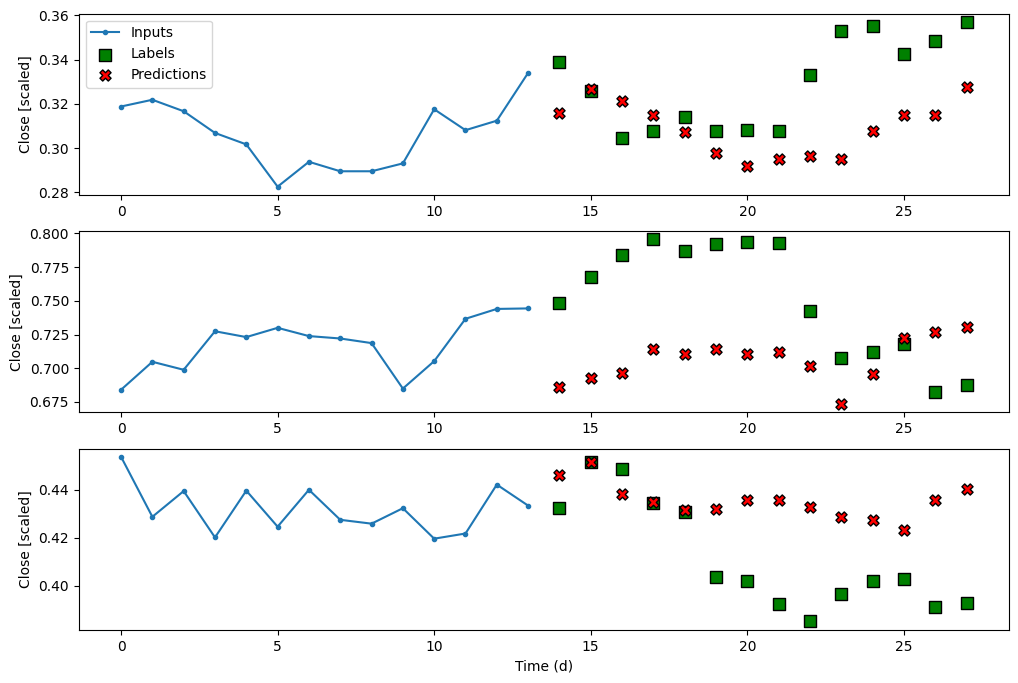

In [ ]:
# Plot the performance of the best LSTM model
multi_window.plot(best_lstm_model)

# Prophet

In [ ]:
#!pip install prophet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from itertools import product
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation, performance_metrics

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define a function to load and preprocess the data
def load_data(csv_file_path):
    df = pd.read_csv(csv_file_path)
    df = df[['Date', 'Close']]
    df['Date'] = pd.to_datetime(df['Date'])
    return df

In [ ]:
# Load and preprocess the data
prophet_df = load_data(path)

In [ ]:
# Rename the columns to 'ds' and 'y'
prophet_df.columns = ['ds', 'y']

In [ ]:
# Create a continuous date range for the entire period
date_range = pd.date_range(start=prophet_df['ds'].min(), end=prophet_df['ds'].max())

# Create a new DataFrame with the date range
date_range_df = pd.DataFrame({'ds': date_range})

# Merge the date range DataFrame with your original dataset, filling in missing dates
prophet_merge = date_range_df.merge(prophet_df, on='ds', how='left')

# Fill in NaN values for weekends (Saturday and Sunday) with a placeholder value or by interpolation
prophet_merge['y'].fillna(np.nan, inplace=True)

In [ ]:
prophet_train = prophet_merge[:-14]
prophet_test = prophet_merge[-14:]
print(prophet_merge.shape, prophet_train.shape, prophet_test.shape)

(7262, 2) (7248, 2) (14, 2)


In [ ]:
prophet_train.tail(2)

,ds,y
7246,2023-10-03,1.048075
7247,2023-10-04,1.047230


In [ ]:
# Create a Prophet model
m = Prophet()

# Fit the model to the merged data
m.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphocso219/_77p1pnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphocso219/bfl5kjwm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39100', 'data', 'file=/tmp/tmphocso219/_77p1pnr.json', 'init=/tmp/tmphocso219/bfl5kjwm.json', 'output', 'file=/tmp/tmphocso219/prophet_modelqam9dl3p/prophet_model-20231022025947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:59:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:59:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create a future DataFrame for the next 14 days
future = m.make_future_dataframe(periods=14)

# Make predictions for the future dates
forecast = m.predict(future)

# Display the forecast for the next 14 days
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(14))

             ds      yhat  yhat_lower  yhat_upper
5149 2023-10-05  1.067907    1.022306    1.114968
5150 2023-10-06  1.067890    1.020719    1.118568
5151 2023-10-07  1.046962    0.995770    1.094210
5152 2023-10-08  1.047053    0.996631    1.094446
5153 2023-10-09  1.067881    1.022491    1.116835
5154 2023-10-10  1.067901    1.021320    1.114257
5155 2023-10-11  1.068473    1.018703    1.117147
5156 2023-10-12  1.068776    1.020932    1.118406
5157 2023-10-13  1.069002    1.021229    1.114938
5158 2023-10-14  1.048289    1.001107    1.094370
5159 2023-10-15  1.048559    1.000373    1.095404
5160 2023-10-16  1.069524    1.017425    1.116265
5161 2023-10-17  1.069634    1.022337    1.118241
5162 2023-10-18  1.070246    1.022817    1.121282


In [ ]:
# merging the train and prediction
prophet_train_pred = prophet_train.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
prophet_train_pred

,ds,y,yhat,yhat_lower,yhat_upper
0,2003-12-01,1.196501,1.213853,1.166462,1.258413
1,2003-12-02,1.208897,1.214481,1.165020,1.263846
2,2003-12-03,1.212298,1.215619,1.166030,1.262331
3,2003-12-04,1.208094,1.216444,1.169679,1.266768
4,2003-12-05,1.218695,1.217153,1.169152,1.264258
...,...,...,...,...,...
7243,2023-09-30,NaN,NaN,NaN,NaN
7244,2023-10-01,NaN,NaN,NaN,NaN
7245,2023-10-02,1.056524,1.067844,1.018848,1.113939
7246,2023-10-03,1.048075,1.067578,1.020574,1.116687


In [ ]:
# calculating the train_mae
prophet_train_pred = prophet_train_pred.dropna(subset=['y'])

prophet_train_pred = mean_absolute_error(prophet_train_pred['y'], prophet_train_pred['yhat'])
print("train MAE for prophet model:", prophet_train_pred)

train MAE for prophet model: 0.029669671128776023


In [ ]:
# merging the test and prediction
prophet_test = prophet_test.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
prophet_test

,ds,y,yhat,yhat_lower,yhat_upper
0,2023-10-05,1.050707,1.067907,1.021993,1.116625
1,2023-10-06,1.054663,1.067890,1.019222,1.115042
2,2023-10-07,NaN,1.046962,1.001242,1.094383
3,2023-10-08,NaN,1.047053,0.999316,1.095286
4,2023-10-09,1.056747,1.067881,1.021498,1.119210
5,2023-10-10,1.057888,1.067901,1.022601,1.111722
6,2023-10-11,1.060479,1.068473,1.024417,1.117656
7,2023-10-12,1.062428,1.068776,1.019077,1.116787
8,2023-10-13,1.053674,1.069002,1.022196,1.119649
9,2023-10-14,NaN,1.048289,1.001574,1.097545


In [ ]:
# calculating the test_mae
prophet_test = prophet_test.dropna(subset=['y'])

prophet_mae = mean_absolute_error(prophet_test['y'], prophet_test['yhat'])
print("Prophet MAE:", prophet_mae)

Prophet MAE: 0.012519676381200417


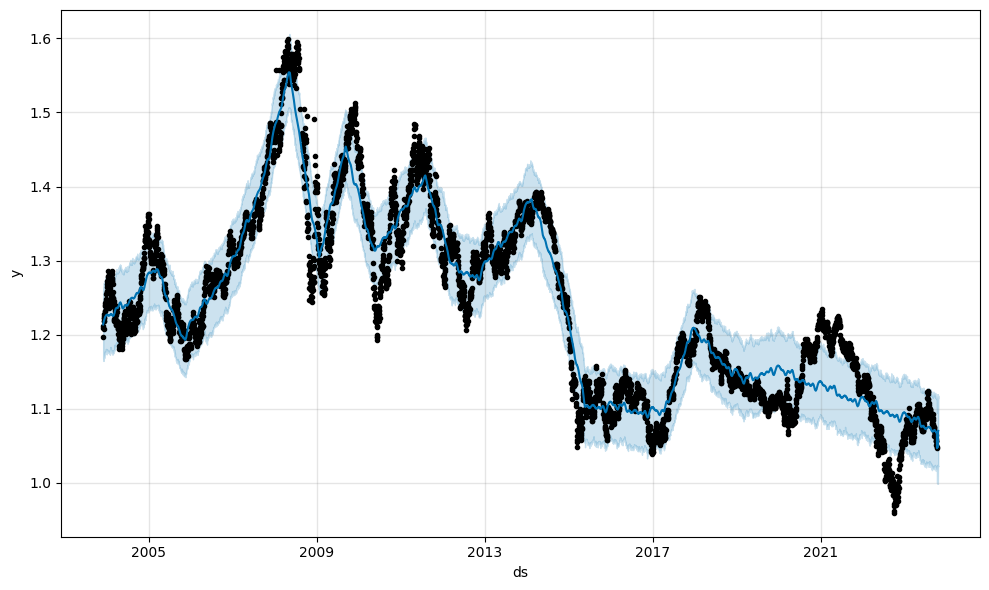

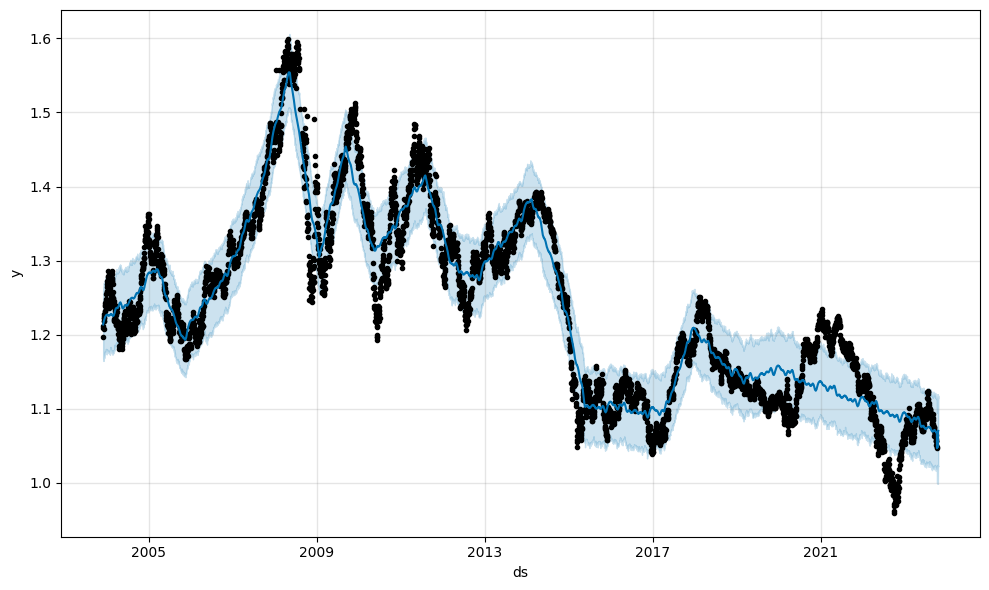

In [ ]:
m.plot(forecast)

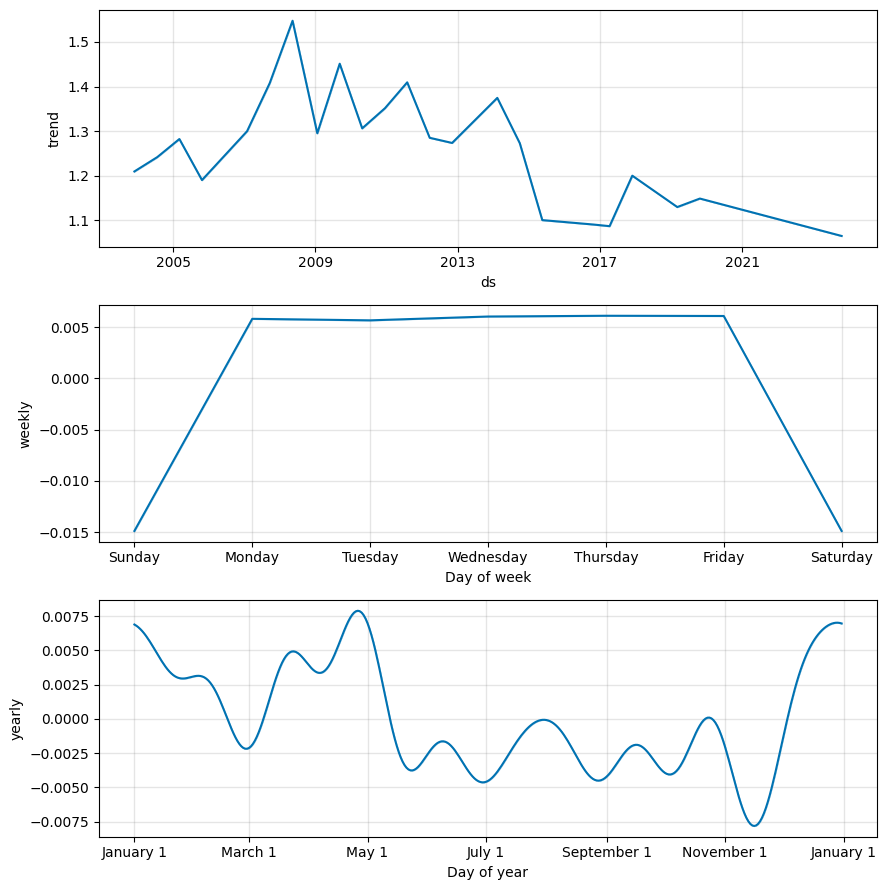

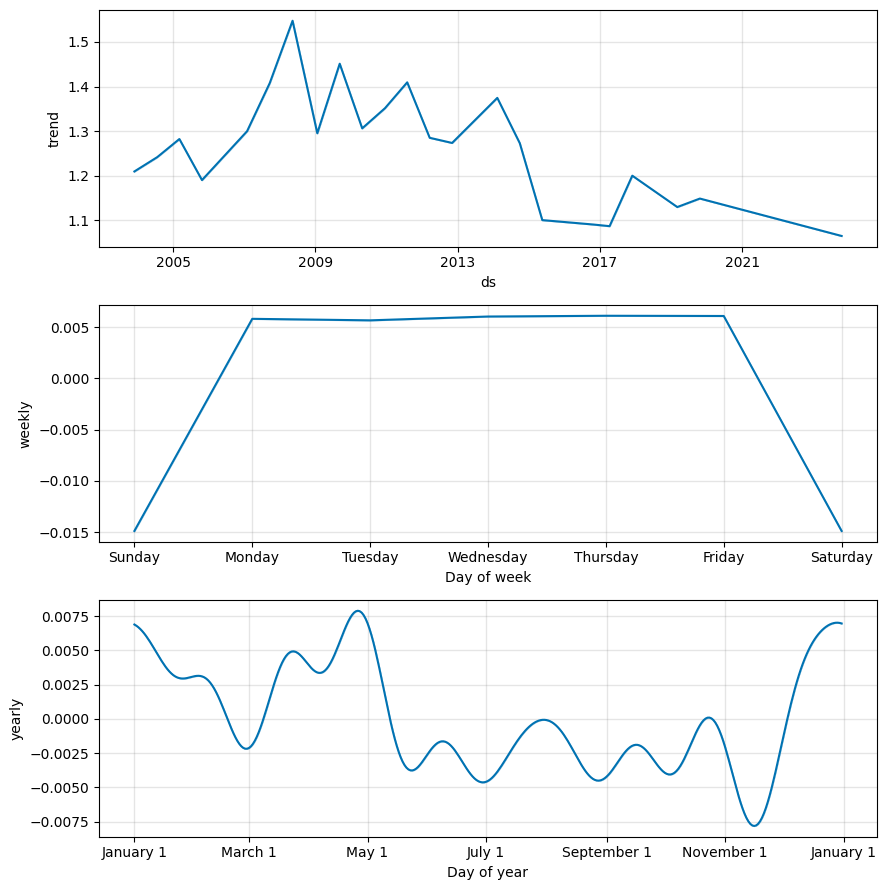

In [ ]:
m.plot_components(forecast)